# Model Balance and Feature Importance

1. Classification models with imbalanced data
1. Visualizing trees
1. Feature importance

As I said last class, the main drawback with ensembles is usually imbalanced classification and interpretation.


In [15]:
# import lots of functions
import pandas as pd
import matplotlib.pyplot as plt  

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder 
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline 
from sklearn.impute import SimpleImputer
from df_after_transform import df_after_transform
from sklearn.model_selection import KFold, cross_validate, GridSearchCV
from sklearn.metrics import confusion_matrix


In [16]:
# load data 
loans = pd.read_csv('lendingclub/2013_subsample.zip')


In [17]:
# split to test and train (link to split page/sk docs)

# first let's separate y from X
y = loans.loan_status == 'Charged Off'
y.value_counts()
loans = loans.drop('loan_status',axis=1)

# stratify will make sure that test/train both have equal fractions of outcome
X_train, X_test, y_train, y_test = train_test_split(loans, y, stratify=y, test_size=.2, random_state=0)


In [18]:
## optimize a series of models 

# set up pipeline to clean each type of variable (1 pipe per var type)

numer_pipe = make_pipeline(SimpleImputer(),StandardScaler()) 
cat_pipe   = make_pipeline(OneHotEncoder(drop='first'))

# combine those pipes into "preprocess" pipe

preproc_pipe = ColumnTransformer(  
    [ # arg 1 of ColumnTransformer is a list, so this starts the list
    # a tuple for the numerical vars: name, pipe, which vars to apply to
    ("num_impute", numer_pipe, ['annual_inc']),
    # a tuple for the categorical vars: name, pipe, which vars to apply to
    ("cat_trans", cat_pipe, ['grade'])
    ]
    , remainder = 'drop' # you either drop or passthrough any vars not modified above
)

Like last lecture, I've imported the Lending Club data. 

Like all real datasets, its outcome variable is imbalanced.

In [19]:
y_train.value_counts(normalize=True).round(3)

False    0.844
True     0.156
Name: loan_status, dtype: float64

## Ways to deal with imbalanced data

1. Add data (oversample underrepresented group) 
    - Slower estimations (more data)
1. Remove data (undersample overrepresented group)
    - Throws data away (hurts predictions!) but estimations faster
    - Tradeoff can be worth it: more speed and possibly similar or better predictions
1. Change estimator to "weight" groups equally
    - `class-weight=’balanced’` in trees, logit
    - like oversampling, except no slowdown

### 🔥🔥🔥 Practical tips: 🔥🔥🔥
- What works best varies between applications (no "dominant")
- Try weighting if estimator will let you, then undersampling

## Examples - dealing with imbalance

So this was last time, predictions of default had a precision of 22%, and only 3% of defaults were predicted in advance. (BAD RECALL!)

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

tree_clf = make_pipeline(preproc_pipe, DecisionTreeClassifier())
tree_clf.fit(X_train, y_train)

tree_clf.predict(X_test).sum() # number of rejections under old model

# print(classification_report(y_test, tree_clf.predict(X_test)) )
# plot_confusion_matrix(tree_clf, X_test, y_test, normalize='pred') 
# plt.show()

611

### Class weighting...

...like oversampling but without increasing the training speed. The tip on dealing with imbalanced data is

> "Try weighting if estimator will let you, then undersampling"

So let's add `class_weight='balanced'` to the Tree.

1. So, how well do we do at predicting loan defaults?
1. How "accurate" is our model?

In [23]:
tree_clf = make_pipeline(preproc_pipe, DecisionTreeClassifier(class_weight='balanced'))
tree_clf.fit(X_train, y_train)
# print(classification_report(y_test, tree_clf.predict(X_test)) )
# plot_confusion_matrix(tree_clf, X_test, y_test, normalize='pred') 
# plt.show()

tree_clf.predict(X_test).sum() # number of rejections under old model


11879

So the lessons here:

1. Beware high accuracy models unless you see the classification report or confusion matrix!
1. Depending on the application, a lower accuracy score might be strongly preferred if sensitivity/recall or precision matters.


### Undersampling (and over)

Undersampling and over sampling can't be done within sklearn pipelines "out of the box", so we will install and use a package that extends the sklearn API.

https://imbalanced-learn.org/

`pip install -U imbalanced-learn`

Compare the recall and accuracy to the last class's version without fixes (3% and 83%).

              precision    recall  f1-score   support

       False       0.89      0.59      0.71     22756
        True       0.22      0.62      0.32      4205

    accuracy                           0.60     26961
   macro avg       0.56      0.61      0.52     26961
weighted avg       0.79      0.60      0.65     26961



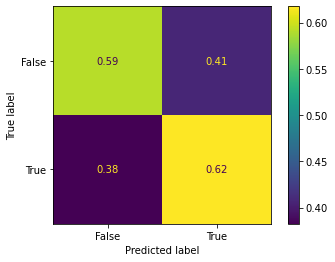

In [8]:
# the under sampler
from imblearn.under_sampling import RandomUnderSampler
# sklearn pipelines won't work for sampling - use the imblearn pipeline
# here I name it differently to clarify that it isnt the sklearn make_pipeline
from imblearn.pipeline import make_pipeline as make_imb_pipeline

tree_clf = make_imb_pipeline(RandomUnderSampler(),
                             preproc_pipe, DecisionTreeClassifier())
tree_clf.fit(X_train, y_train)
print(classification_report(y_test, tree_clf.predict(X_test)) )
plot_confusion_matrix(tree_clf, X_test, y_test, normalize='true')
plt.show()

Over sampling is procedurally the same. 

In this example, the recall on defaults is a little lower than the undersampling (way to go undersampling!), while most other numbers are slightly higher.

              precision    recall  f1-score   support

       False       0.89      0.60      0.72     22756
        True       0.22      0.61      0.32      4205

    accuracy                           0.60     26961
   macro avg       0.55      0.60      0.52     26961
weighted avg       0.79      0.60      0.65     26961



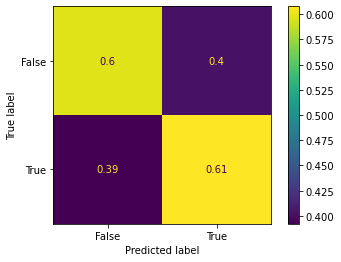

In [9]:
from imblearn.over_sampling import RandomOverSampler

tree_clf = make_imb_pipeline(RandomOverSampler(),
                             preproc_pipe, DecisionTreeClassifier())
tree_clf.fit(X_train, y_train)
print(classification_report(y_test, tree_clf.predict(X_test)) )
plot_confusion_matrix(tree_clf, X_test, y_test, normalize='true')
plt.show()

## Visualizing trees

1. Plotting a tree: `tree.plot_tree(<tree object>)`
    - Good idea: Restrict depth to 3 or so layers, then plot
    - `dtreeviz` is a really nice tree visualizing package
    - Other
1. Plot the "decision surface". 
    - Can be a pain with real data...

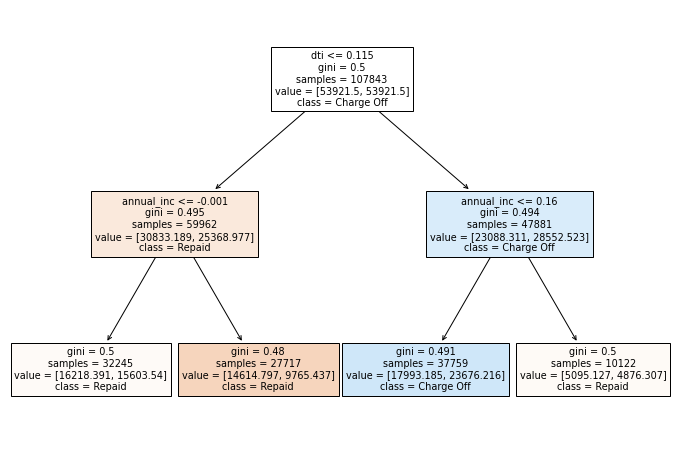

In [28]:
# i'm just changing this to only use 2 numerical values
preproc_pipe = ColumnTransformer([("num_impute", numer_pipe, ['annual_inc','dti'])]
                                , remainder = 'drop')

# only do tree to 2 levels
tree_clf = make_pipeline(preproc_pipe, 
                         DecisionTreeClassifier(class_weight='balanced',
                                                max_depth=2))
tree_clf.fit(X_train, y_train)

from sklearn import tree
fig, ax = plt.subplots(figsize=(12,8))
tree.plot_tree(tree_clf['decisiontreeclassifier'], ax=ax,
              filled=True,feature_names = ['annual_inc','dti'],
              class_names = ['Repaid','Charge Off'])
plt.show()

In [11]:
from df_after_transform import df_after_transform
import numpy as np

X = df_after_transform(preproc_pipe,X_train)
y = y_train.copy() # from https://scikit-learn.org/stable/auto_examples/tree/plot_iris_dtc.html



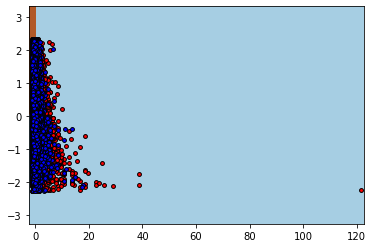

In [12]:
n_classes = 2
# define bounds of the domain
min1, max1 = X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1
min2, max2 = X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1
# define the x and y scale
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)
# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)
# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2))
# define the model
model = tree_clf
# fit the model
model.fit(X, y)
# make predictions for the grid
yhat = model.predict(pd.DataFrame(grid,columns=['annual_inc','dti']))
# reshape the predictions back into a grid
zz = yhat.reshape(xx.shape)
# plot the grid of x, y and z values as a surface
plt.contourf(xx, yy, zz, cmap='Paired')
# create scatter plot for samples from each class
# Plot the training points
for i, color in zip(range(n_classes), "rb"):
    idx = np.where(y == i)
    plt.scatter(X.values[idx, 0], X.values[idx, 1], c=color, 
                cmap=plt.cm.RdYlBu, edgecolor='black', s=15) #label=iris.target_names[i],
plt.show()


## Feature importance

- One way to visualize importance
- Akin to looking at top levels of a tree
- Caution

In [13]:
tree_clf = make_pipeline(preproc_pipe, DecisionTreeClassifier())
tree_clf.fit(X_train, y_train)
importances = tree_clf['decisiontreeclassifier'].feature_importances_

importances = pd.DataFrame(importances, 
                               index=df_after_transform(preproc_pipe,X_train).columns
)
importances

,0
annual_inc,0.390699
dti,0.609301
